In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from neuromaps.datasets import fetch_fslr
from sklearn.preprocessing import StandardScaler
import fbpca
import h5py
from scipy.signal import hilbert

from heteromodes.utils import load_hmap, unmask
from heteromodes.plotting import plot_brain, plot_heatmap
from heteromodes import EigenSolver
from heteromodes.restingstate import simulate_bold, calc_gen_phase, filter_bold

In [2]:
n_runs = 5

In [3]:
den = "4k"
surf = fetch_fslr(den)["midthickness"][0]
surf_infl = fetch_fslr(den)["inflated"][0]
hmap = load_hmap("myelinmap", den)
medmask = nib.load(f"{PROJ_DIR}/data/empirical/fsLR-4k_medmask.label.gii").darrays[0].data.astype(bool)

In [4]:
nT = 1200
def run_model(surf, medmask, hmap, params, n_modes=500, n_runs=5, scaling=None, q_norm=None):
    nverts = np.sum(medmask)
    
    # Try solve eigenvalues and eigenvectors. If it doesn't work then return None
    try:
        solver = EigenSolver(surf=surf, medmask=medmask,  hetero=hmap, alpha=params[0], sigma=params[3], 
                             scaling=scaling, q_norm=q_norm)
        evals, emodes = solver.solve(n_modes=n_modes, fix_mode1=True, standardise=True)
    # TODO: Only catch error when invalid parameter combinations are used
    except ValueError:
        return None, None

    # Z-score bold data
    scaler = StandardScaler()

    # Simulate BOLD data and calculate FC and phase
    bold = np.empty((nverts, nT, n_runs))
    for run in range(n_runs):
        # Load external input, run model and parcellate
        ext_input = np.load(f"{PROJ_DIR}/data/resting_state/extInput_parc-None_den-{den}_nT-{nT}_randseed-{run}.npy")
        bold_run = simulate_bold(evals, emodes, ext_input, solver_method='Fourier', 
                             eig_method='orthogonal', r=params[1], gamma=params[2], mass=solver.mass)
        bold[:, :, run] = scaler.fit_transform(bold_run.T).T
        
    return bold

## Hom. model

In [5]:
bold_hom = run_model(surf=surf, hmap=None, medmask=medmask, params=(0, 28.9, 0.116, 0))
bold_hom_stacked = np.hstack([bold_hom[:, :, i] for i in range(n_runs)])

In [19]:
n_comp = 4
l = 10 + n_comp
# phase_hom = calc_gen_phase(bold_hom_stacked, tr=0.72, lowcut=0.01, highcut=0.1)
phase_hom = hilbert(filter_bold(bold_hom_stacked, tr=0.72, lowcut=0.01, highcut=0.1), axis=1).conj()
U_hom, S_hom, V_hom = fbpca.pca(phase_hom.T, k=n_comp, n_iter=20, l=l)


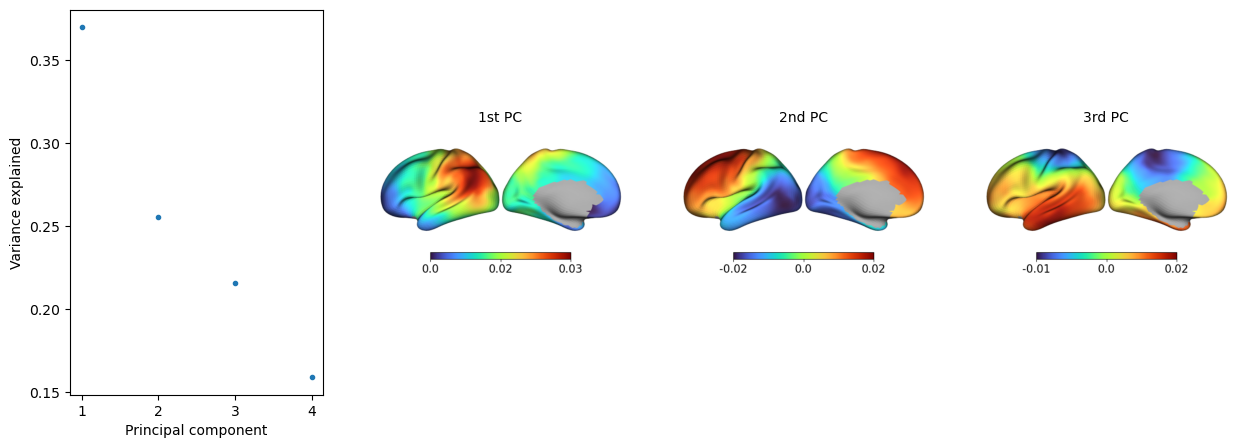

In [20]:
# svd = TruncatedSVD(n_components=n_comp).fit_transform(phase_hom)
# U_hom, S_hom, V_hom = np.linalg.svd(phase_hom, full_matrices=False)

# Plot variance explained
expl_var = S_hom[:n_comp]**2 / (np.shape(phase_hom)[1] - 1)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(expl_var / np.sum(expl_var), ".")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Variance explained")
axs[0].set_xticks(np.arange(0, n_comp))
axs[0].set_xticklabels(np.arange(1, n_comp+1))

# Plot first component
data = np.real(V_hom[:3, :].T)
# data = (V_hom[:3, :].T @ np.diag(S_hom[:3])) / np.sqrt(np.shape(phase_hom)[1] - 1)
plot_brain(surf_infl, unmask(data, medmask), cmap="turbo", cbar=True, ax=[axs[1], axs[2], axs[3]], labels=["1st PC", "2nd PC", "3rd PC"])
plt.show()

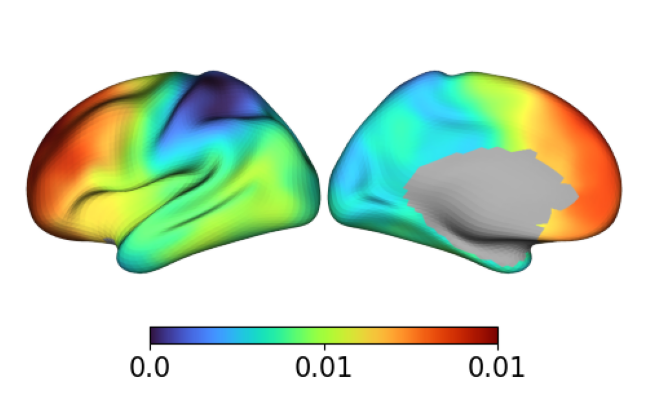

In [22]:
combined_hom = np.sum(np.real(V_hom).T @ np.diag(S_hom), axis=1) / np.sum(S_hom)
fig = plt.figure(figsize=(10, 5))
plot_brain(surf_infl, unmask(combined_hom, medmask), cmap="turbo", cbar=True, ax=fig.gca())

## Het. model

In [23]:
params_het = (2, 28.9, 0.116, 0)
scaling = "sigmoid"
q_norm = None

In [ ]:
bold_het = run_model(surf=surf, hmap=hmap, medmask=medmask, params=params_het, scaling=scaling, q_norm=q_norm)
bold_het = np.hstack([bold_het[:, :, i] for i in range(n_runs)])

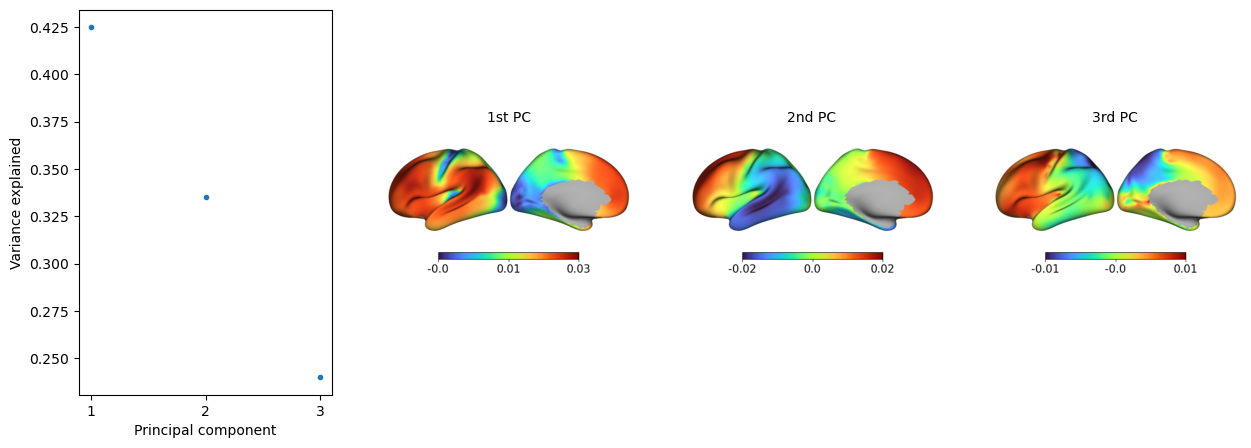

In [ ]:
# phase_het = calc_gen_phase(bold_het, tr=0.72, lowcut=0.01, highcut=0.1)
phase_het = hilbert(filter_bold(bold_het, tr=0.72, lowcut=0.01, highcut=0.1), axis=1).conj()
U_het, S_het, V_het = fbpca.pca(phase_het.T, k=n_comp, n_iter=20, l=l)
# svd = TruncatedSVD(n_components=n_comp).fit_transform(phase_het)
# U_het, S_het, V_het = np.linalg.svd(phase_het, full_matrices=False)

# Plot variance explained
expl_var = S_het[:n_comp]**2 / (np.shape(phase_het)[1] - 1)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(expl_var / np.sum(expl_var), ".")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Variance explained")
axs[0].set_xticks(np.arange(0, n_comp))
axs[0].set_xticklabels(np.arange(1, n_comp+1))

# Plot first component
data = np.real(V_het[:3, :].T)
# data = (V_het[:3, :].T @ np.diag(S_het[:3])) / np.sqrt(np.shape(phase_het)[1] - 1)
plot_brain(surf_infl, unmask(data, medmask), cmap="turbo", cbar=True, ax=[axs[1], axs[2], axs[3]], labels=["1st PC", "2nd PC", "3rd PC"])
plt.show()

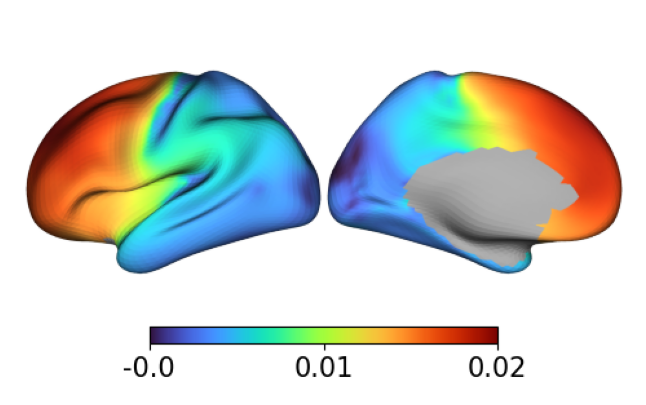

In [ ]:
combined_het = np.sum(np.real(V_het).T @ np.diag(S_het), axis=1) / np.sum(S_het)
fig = plt.figure(figsize=(10, 5))
plot_brain(surf_infl, unmask(combined_het, medmask), cmap="turbo", cbar=True, ax=fig.gca())

## Empirical

In [ ]:
with h5py.File(f"{PROJ_DIR}/data/empirical/HCP_nsubj-255_complexPhase_parc-None_fsLR4k_hemi-L_freql-0.01_freqh-0.1.h5", "r") as f:
    phase_cpcs_emp = f["phase_cpcs_group"][:]
    svals_emp = f["svals_group"][:]

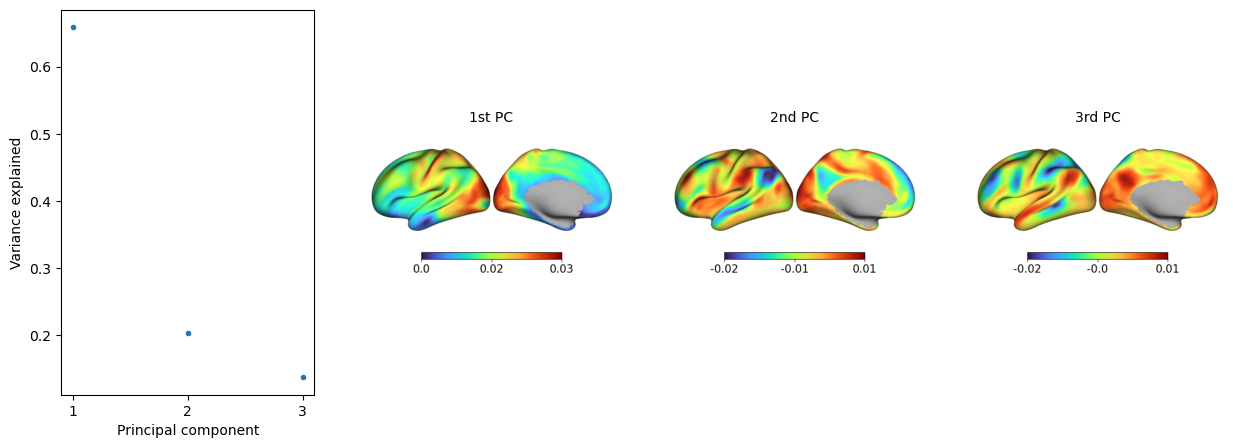

In [ ]:
# Plot variance explained
expl_var = svals_emp[:n_comp]**2 / (np.shape(phase_cpcs_emp)[1] - 1)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(expl_var / np.sum(expl_var), ".")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Variance explained")
axs[0].set_xticks(np.arange(0, n_comp))
axs[0].set_xticklabels(np.arange(1, n_comp+1))

plot_brain(surf_infl, unmask(phase_cpcs_emp[:, :3], medmask), cmap="turbo", cbar=True, ax=[axs[1], axs[2], axs[3]], labels=["1st PC", "2nd PC", "3rd PC"])
plt.show()

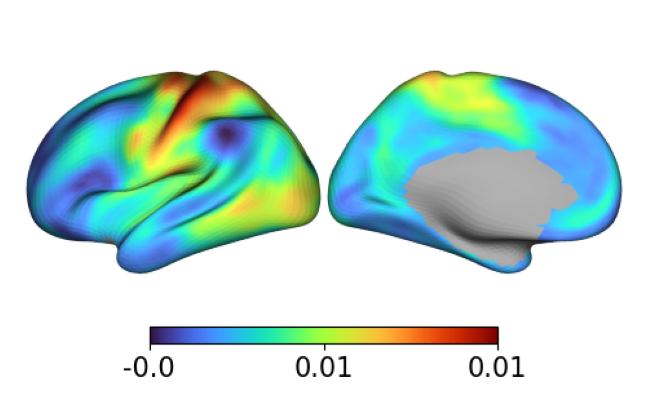

In [ ]:
combined_emp = np.sum(phase_cpcs_emp @ np.diag(svals_emp), axis=1) / np.sum(svals_emp)
fig = plt.figure(figsize=(10, 5))
plot_brain(surf_infl, unmask(combined_emp, medmask), cmap="turbo", cbar=True, ax=fig.gca())

In [ ]:
aa = np.arange(21).reshape(7, 3)
print(aa)
bb = np.arange(3)
print(bb)

cc = aa * bb
print(cc)

dd = np.sum(cc, axis=1)
print(dd)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[0 1 2]
[[ 0  1  4]
 [ 0  4 10]
 [ 0  7 16]
 [ 0 10 22]
 [ 0 13 28]
 [ 0 16 34]
 [ 0 19 40]]
[ 5 14 23 32 41 50 59]


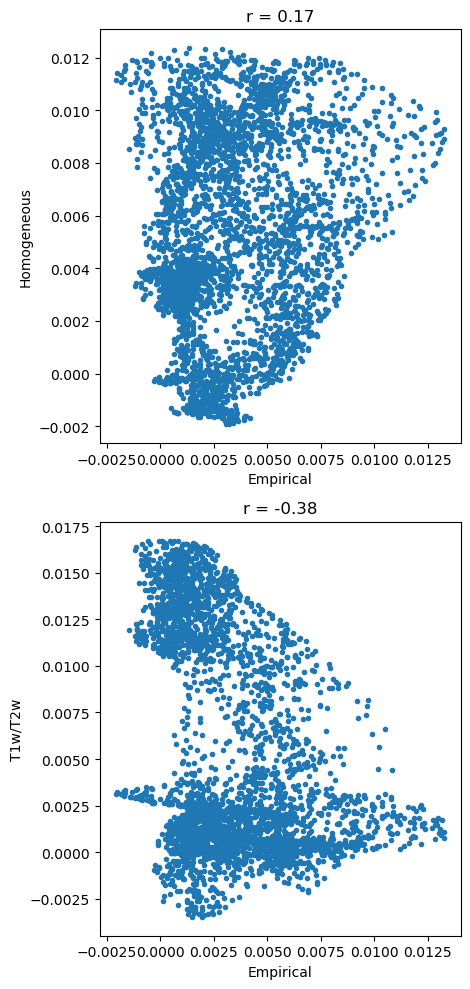

In [ ]:
from scipy.stats import spearmanr

fig, axs = plt.subplots(2, 1, figsize=(5, 10))

pc_id = 2
# emp = np.real(phase_cpcs_emp[:, pc_id])
# het = np.real(V_het[pc_id, :])
# hom = np.real(V_hom[pc_id, :])
emp = combined_emp
het = combined_het
hom = combined_hom

axs[0].plot(emp, hom, '.')
axs[0].set_xlabel("Empirical")
axs[0].set_ylabel("Homogeneous")
# corr_hom = spearmanr(pc1_emp, pc1_hom).correlation
corr_hom = np.corrcoef(emp, hom)[0, 1]
axs[0].set_title(f"r = {corr_hom:.2f}")

axs[1].plot(emp, het, '.')
axs[1].set_xlabel("Empirical")
axs[1].set_ylabel("T1w/T2w")
# corr_het = spearmanr(pc1_emp, pc1_het).correlation
corr_het = np.corrcoef(emp, het)[0, 1]
axs[1].set_title(f"r = {corr_het:.2f}")

plt.tight_layout()